In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import csv
data = []
with open("cleaned/NY.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-300]
test = data[-300:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-300]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-300:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([439, 2, 1])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [5]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) #Learning Rate
loss_fun = nn.MSELoss()

In [6]:
model.train()
list_l = []
list_tl = []
for epoch in range(1200):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    list_l.append(loss)
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        list_tl.append(test_loss)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:7.367792129516602, test_loss: 67.10722351074219
epoch:40, loss:2.3510682582855225, test_loss: 47.76401901245117
epoch:60, loss:1.114704966545105, test_loss: 40.07990264892578
epoch:80, loss:0.7314466238021851, test_loss: 36.04498291015625
epoch:100, loss:0.5734690427780151, test_loss: 33.30935287475586
epoch:120, loss:0.4679231345653534, test_loss: 31.329561233520508
epoch:140, loss:0.4080944061279297, test_loss: 29.840957641601562
epoch:160, loss:0.3830881416797638, test_loss: 28.796669006347656
epoch:180, loss:0.3735540211200714, test_loss: 28.116132736206055
epoch:200, loss:0.3695901930332184, test_loss: 27.65837287902832
epoch:220, loss:0.3677982985973358, test_loss: 27.336368560791016
epoch:240, loss:0.36677807569503784, test_loss: 27.0975341796875
epoch:260, loss:0.3660084307193756, test_loss: 26.918283462524414
epoch:280, loss:0.3654804825782776, test_loss: 26.778520584106445
epoch:300, loss:0.3649842441082001, test_loss: 26.668983459472656
epoch:320, loss:0.36454

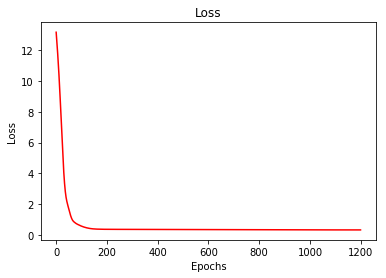

In [7]:
num_list = []
for i in range(len(list_l)):
    num_list.append(list_l[i].item())
x = np.array([i for i in range(len(list_l))])
#print(num_list)
plt.plot(x, num_list, color='r')
#plt.plot(x, num_list_, color='k')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('plot/NY_Loss.jpg')
plt.show()

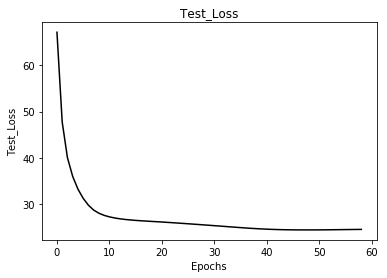

In [8]:
num_list_ = []
for i in range(len(list_tl)):
    num_list_.append(list_tl[i].item())
x = np.array([i for i in range(len(num_list_))])
#plt.plot(x, num_list, color='r')
plt.plot(x, num_list_, color='k')
plt.title('Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Test_Loss')
plt.savefig('plot/NY_Test_Loss.jpg')
plt.show()

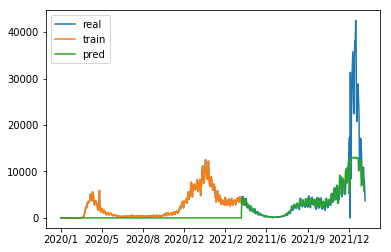

In [9]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.savefig('plot/NY_Epoch1200.jpg')

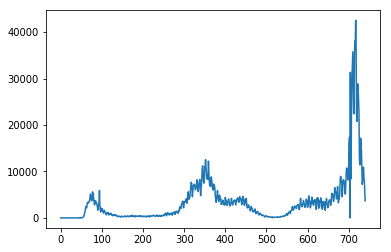

In [10]:
plt.plot(data)

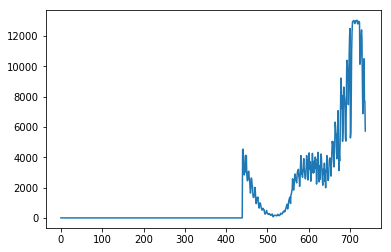

In [11]:
plt.plot(result)

In [12]:
# unpredictive
# 